# Git 分析 Notebook
统计每个 commit 中各个预定义技术栈文件的代码量等级文件数量分布

### 从Data路径下加载多个分析结果

In [3]:
from notebook_utils import select_repo_and_run, set_cjk_font

set_cjk_font()

base_dir="../data"
repo_selector, run_selector = select_repo_and_run(base_dir)

✅ 已设置字体为：Arial Unicode MS


Dropdown(description='Repo:', layout=Layout(width='50%'), options=('git2base',), value='git2base')

Dropdown(description='Run:', layout=Layout(width='50%'), options=('snapshot_20250728_155908', 'snapshot_202507…

### 从选择路径下加载CSV

In [4]:
from typing import cast

from pandas import DataFrame
from notebook_utils import load_csv_results

selected_path, loaded_dfs = load_csv_results(repo_selector, run_selector, base_dir)

# 使用具体的 DataFrame
commit_files_df = cast(DataFrame, loaded_dfs.get("commit_files_df"))
diff_results_df = cast(DataFrame, loaded_dfs.get("diff_results_df"))
analysis_results_df = cast(DataFrame, loaded_dfs.get("analysis_results_df"))
commits_df = cast(DataFrame, loaded_dfs.get("commits_df"))

Selected path: ../data/git2base/snapshot_20250728_155908
✅ Loaded: commit_files.csv (27 rows)
❌ File not found: diff_results.csv
✅ Loaded: analysis_results.csv (16 rows)
✅ Loaded: commits.csv (1 rows)


### 合并数据

In [5]:
import pandas as pd

# 重命名 commits.csv 中的 hash 字段
commits_df = commits_df.rename(columns={"hash": "commit_hash"})

# 合并 commit_files 和 analysis_results（依据 commit_hash 和 path）
merged_df = pd.merge(commit_files_df, analysis_results_df, on=["commit_hash", "path"], how="left")

# 合并 commit 元数据
merged_df = pd.merge(merged_df, commits_df, on="commit_hash", how="left")
merged_df["analyzer_type"].unique()


array([nan, 'FileLineCount', 'FileCharCount'], dtype=object)

### 提取行数和字符数的记录

In [6]:
# 提取 line_count 和 char_count 两种分析类型的记录
line_df = merged_df[merged_df["analyzer_type"] == "FileLineCount"]
char_df = merged_df[merged_df["analyzer_type"] == "FileCharCount"]

### 统计每个技术栈代码的代码量等级文件数分布

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 提取 char_count 分析结果
char_df = merged_df[merged_df["analyzer_type"] == "FileCharCount"].copy()

# 定义分界点
bins = [0, 1000, 2000, 3000, 10000, 50000, float("inf")]

# 定义对应的标签
labels = ["<1k", "1k-2k", "2k-3k", "3k-10k", "10k-50k", ">=50k"]

# 添加一个等级列
char_df["char_level"] = pd.cut(char_df["count"], bins=bins, labels=labels, right=False)

char_stats = (
    char_df.groupby(["tech_stack", "char_level"], observed=True)
      .size()
      .unstack(fill_value=0)
)
char_stats

char_level,1k-2k,2k-3k,3k-10k,10k-50k
tech_stack,,,,
PyTest,0,1,0,0
Python,0,2,3,1
Yaml,1,0,0,0


### 绘制文件分布柱状图（按各个等级的文件数量）

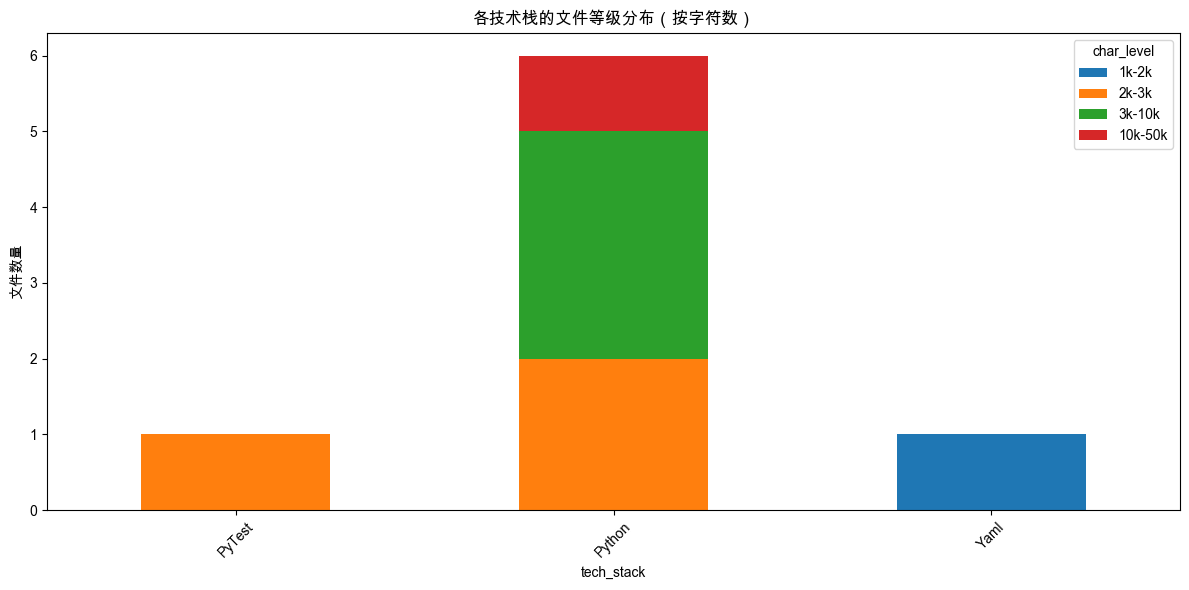

In [8]:
char_stats.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("各技术栈的文件等级分布（按字符数）")
plt.ylabel("文件数量")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 保存结果为 CSV

In [9]:
char_stats.to_csv("output/filechar_agg_by_techstack.csv", index=False)
print("✅ 已保存分析结果至 output/filechar_agg_by_techstack.csv")


✅ 已保存分析结果至 output/filechar_agg_by_techstack.csv
